<a href="https://colab.research.google.com/github/tayiba-r/oral-cancer-detection/blob/main/code/OSCCC_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Making necessary Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil # move files from one folder to other
import math
import glob

In [3]:
# 'rm -rf `find -type d -name .ipynb_checkpoints`'
# 'rm .ipynb_checkpoints'

## **Copy the dataset from Drive and unzip it**

In [4]:
!cp -r "/content/drive/MyDrive/Oral_cancer/OSCC_dataset.zip" "/content/"

In [5]:
!unzip /content/OSCC_dataset.zip

Archive:  /content/OSCC_dataset.zip
   creating: Second Set/
  inflating: __MACOSX/._Second Set   
   creating: Second Set/400x Normal Oral Cavity Histopathological Images/
  inflating: __MACOSX/Second Set/._400x Normal Oral Cavity Histopathological Images  
   creating: Second Set/400x OSCC Histopathological Images/
  inflating: __MACOSX/Second Set/._400x OSCC Histopathological Images  
  inflating: Second Set/400x Normal Oral Cavity Histopathological Images/Normal_400x_46.jpg  
  inflating: __MACOSX/Second Set/400x Normal Oral Cavity Histopathological Images/._Normal_400x_46.jpg  
  inflating: Second Set/400x Normal Oral Cavity Histopathological Images/Normal_400x_52.jpg  
  inflating: __MACOSX/Second Set/400x Normal Oral Cavity Histopathological Images/._Normal_400x_52.jpg  
  inflating: Second Set/400x Normal Oral Cavity Histopathological Images/Normal_400x_85.jpg  
  inflating: __MACOSX/Second Set/400x Normal Oral Cavity Histopathological Images/._Normal_400x_85.jpg  
  inflating:

## **Rename the dataset for better access and readability**

In [6]:
import os

old_name = r"/content/Second Set"
new_name = r"/content/OSCC_dataset"
os.rename(old_name, new_name)

In [7]:
old_name_1 = r"/content/OSCC_dataset/400x Normal Oral Cavity Histopathological Images"
new_name_1 = r"/content/OSCC_dataset/Oral_Cavity_images"
os.rename(old_name_1, new_name_1)

In [8]:
old_name = r"/content/OSCC_dataset/400x OSCC Histopathological Images/"
new_name = r"/content/OSCC_dataset/normal_images/"
os.rename(old_name, new_name)

In [9]:
ROOT_DIR = '/content/OSCC_dataset'
num_of_images = {}

for dir in os.listdir(ROOT_DIR):
  num_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

num_of_images.items()

dict_items([('normal_images', 495), ('Oral_Cavity_images', 201)])

## **Resize all the images to maintain consistency**

In [10]:
# re-size all the images

from PIL import Image
import os

def re_size_function(sub_dir_name):
  input_dir = '/content/OSCC_dataset/'+sub_dir_name
  output_dir_path = '/content/OSCC_resized_dataset/'+sub_dir_name
  image_size = (224, 224) # desired image size 

  output_dir = output_dir_path
  os.makedirs(output_dir)

  if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# Loop through all files in the input directory
  #final_dir = input_dir+"/"+sub_dir_name
  for filename in os.listdir(input_dir):
     if filename.endswith('.jpg') or filename.endswith('.png'): # process only image files
          # Load the image and resize it
          img = Image.open(os.path.join(input_dir, filename))
          img = img.resize(image_size, Image.ANTIALIAS)
        
         # Save the resized image to the output directory
          output_path = os.path.join(output_dir, filename)
          img.save(output_path)

In [11]:
re_size_function('Oral_Cavity_images')
re_size_function('normal_images')

## **Create separate folders for test, validation and testing dataset**

In [12]:
import os
import shutil
import random

def data_folder_creator(source_dir, dest_dir):
    # create the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # create subdirectories for train, test, and validation sets
    for subdir in ['train', 'test', 'val']:
        subdir_path = os.path.join(dest_dir, subdir)
        os.makedirs(subdir_path)
        
        # create subdirectories for cancer and non-cancer classes
        for class_name in ['Oral_Cavity_images', 'normal_images']:
            class_path = os.path.join(subdir_path, class_name)
            os.makedirs(class_path)
    
    # loop over the cancer and non-cancer directories in the source directory
    for class_name in ['Oral_Cavity_images', 'normal_images']:
        class_dir = os.path.join(source_dir, class_name)
        
        # get a list of all images in the class directory
        images = os.listdir(class_dir)
        num_images = len(images)
        
        # shuffle the list of images
        random.shuffle(images)
        
        # calculate the number of images for each set
        num_train = int(0.7 * num_images)
        num_test = int(0.15 * num_images)
        num_val = num_images - num_train - num_test
        
        # copy the images to the train, test, and validation sets
        for i, image in enumerate(images):
            if i < num_train:
                dest_path = os.path.join(dest_dir, 'train', class_name, image)
            elif i < num_train + num_test:
                dest_path = os.path.join(dest_dir, 'test', class_name, image)
            else:
                dest_path = os.path.join(dest_dir, 'val', class_name, image)
            
            src_path = os.path.join(class_dir, image)
            shutil.copy(src_path, dest_path)


In [13]:
source_dir = '/content/OSCC_resized_dataset'
dest_dir = '/content/split_dataset'
data_folder_creator(source_dir, dest_dir)

In [14]:
num_of_images = {}
dir_path= '/content/split_dataset/val'
for dir in os.listdir(dir_path):
  num_of_images[dir] = len(os.listdir(os.path.join(dir_path, dir)))

num_of_images.items()

dict_items([('normal_images', 75), ('Oral_Cavity_images', 31)])

## **Preprocess all the images**

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
"Input : Path ; output : Pre processing Images"

def preprocessing_Images(path):
  image_data = ImageDataGenerator(zoom_range=0.2 , shear_range=0.2 , 
                                  rescale=1/255, horizontal_flip= True)  # data augmentation
  img = image_data.flow_from_directory(directory = path, target_size=(224,224), 
                                       batch_size=32 , class_mode='binary' ) # no need to channel size , i.,e RGB
  return img



In [17]:
training_dataset_path = '/content/split_dataset/train'
train_data = preprocessing_Images(training_dataset_path)

Found 486 images belonging to 2 classes.


In [18]:
# for validation
def preprocessing_Images_2(path):
  image_data = ImageDataGenerator(rescale=1/255)
  img = image_data.flow_from_directory(directory = path, target_size=(224,224), batch_size=32 , class_mode='binary' ) # no need to channel size , i.,e RGB
  return img  

In [19]:
val_dataset_path = '/content/split_dataset/val'
val_data = preprocessing_Images_2(val_dataset_path)

Found 106 images belonging to 2 classes.


In [20]:
test_dataset_path = '/content/split_dataset/test'
test_data = preprocessing_Images_2(test_dataset_path)

Found 104 images belonging to 2 classes.


## **Train the model**

In [21]:
# Import necessary libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


In [22]:
# Set hyperparameters
batch_size = 32
num_epochs = 20
learning_rate = 0.0001
dropout_rate = 0.5


In [23]:
# Define model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_rate))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_rate))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_rate))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))


In [24]:
# Compile model
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [25]:
# Train model
history = model.fit_generator(train_data, steps_per_epoch=len(train_data), 
                              epochs=num_epochs, validation_data=val_data, 
                              validation_steps=len(val_data))

Epoch 1/20
16/16 [==============================] - 75s 4s/step - loss: 0.9357 - accuracy: 0.6070 - val_loss: 0.6410 - val_accuracy: 0.7075
Epoch 2/20
16/16 [==============================] - 71s 4s/step - loss: 0.7735 - accuracy: 0.6049 - val_loss: 0.6856 - val_accuracy: 0.6887
Epoch 3/20
16/16 [==============================] - 72s 4s/step - loss: 0.6542 - accuracy: 0.6626 - val_loss: 0.6642 - val_accuracy: 0.7075
Epoch 4/20
16/16 [==============================] - 72s 4s/step - loss: 0.6306 - accuracy: 0.7119 - val_loss: 0.6824 - val_accuracy: 0.7075
Epoch 5/20
16/16 [==============================] - 73s 4s/step - loss: 0.6327 - accuracy: 0.7140 - val_loss: 0.6760 - val_accuracy: 0.7075
Epoch 6/20
16/16 [==============================] - 72s 4s/step - loss: 0.6259 - accuracy: 0.7119 - val_loss: 0.6729 - val_accuracy: 0.7075
Epoch 7/20
16/16 [==============================] - 71s 4s/step - loss: 0.6168 - accuracy: 0.7099 - val_loss: 0.6819 - val_accuracy: 0.7075
Epoch 8/20
16/16 [==

## **Evaluate the model**

In [26]:
# Evaluate model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('/content/split_dataset/test', 
                                                  target_size=(224, 224), batch_size=batch_size, 
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))

Found 104 images belonging to 2 classes.


In [44]:
# Model graphical interpretation

h = history.history

h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

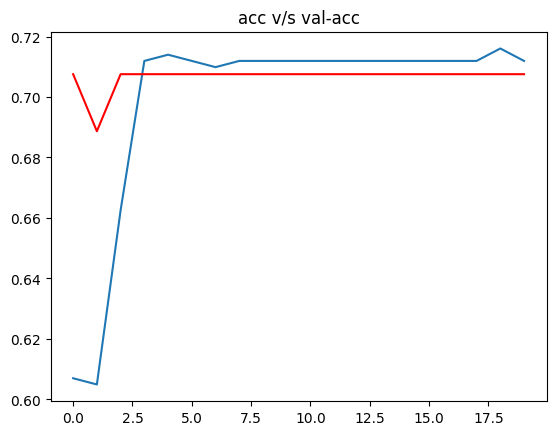

In [45]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')

plt.title('acc v/s val-acc')
plt.show()

In [ ]:
print(h['accuracy'])
print(h['val_accuracy'])

[0.6069958806037903, 0.604938268661499, 0.6625514626502991, 0.7119341492652893, 0.7139917612075806, 0.7119341492652893, 0.709876537322998, 0.7119341492652893, 0.7119341492652893, 0.7119341492652893, 0.7119341492652893, 0.7119341492652893, 0.7119341492652893, 0.7119341492652893, 0.7119341492652893, 0.7119341492652893, 0.7119341492652893, 0.7119341492652893, 0.7160493731498718, 0.7119341492652893]
[0.7075471878051758, 0.6886792182922363, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758, 0.7075471878051758]


## **Early stopping**

In [27]:
# Early stopping : while training model result might come up early , to stop this

from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping

early_stopping = EarlyStopping(monitor= "val_accuracy" , min_delta=0.01, 
                               patience= 3, verbose = 1 , mode ='auto' ) # patience can be altered


model_checkpoint = ModelCheckpoint(monitor= "val_accuracy" , mode ='auto', 
                                 filepath="./bestpath.h5", verbose =1  , save_best_only = True ) 

call_backs = [early_stopping,model_checkpoint]

In [28]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.6527894735336304
Test accuracy: 0.7115384340286255


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

## **Extracting labels for images in test set**

In [30]:
test_labels = []
for i in range(len(test_generator)):
    _, batch_labels = test_generator[i]
    for label in batch_labels:
        test_labels.append(label)
test_labels = np.array(test_labels)

## **Compute the area under the curve (AUC)**

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on test data
test_predictions = model.predict_generator(test_generator, steps=len(test_generator))
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)


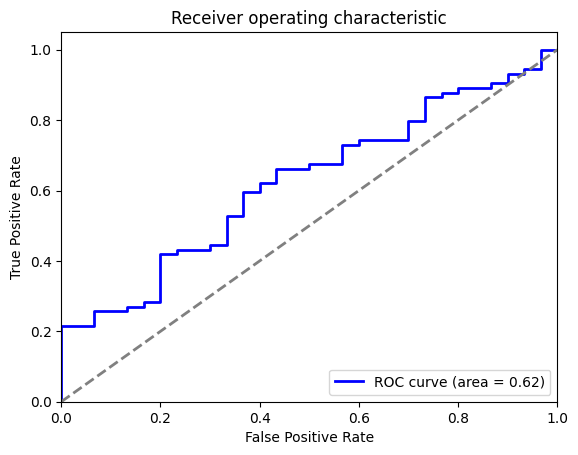

In [42]:
# Calculate AUC
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

## **Compute the sensitivity**

In [33]:
from sklearn.metrics import roc_curve, auc
import numpy as np


# Define threshold value
threshold = 0.5

# Find index of threshold value
idx = np.argmin(np.abs(thresholds - threshold))

# Calculate sensitivity at threshold value
sensitivity = np.interp(threshold, thresholds, tpr)

print("AUC score: ", auc_score)
print("Sensitivity at threshold {}: {}".format(threshold, sensitivity))


AUC score:  0.6238738738738738
Sensitivity at threshold 0.5: 0.0


## **Compute specificity with two-sided 95% confidence intervals**

In [34]:
# Calculate true negatives and false positives for different thresholds
specificities = []
for threshold in thresholds:
    tn = 0
    fp = 0
    for i in range(len(test_predictions)):
        if test_predictions[i] < threshold and test_labels[i] == 0:
            tn += 1
        elif test_predictions[i] >= threshold and test_labels[i] == 0:
            fp += 1
    specificity = tn / (tn + fp)
    specificities.append(specificity)

In [35]:
# Calculate mean and standard deviation of specificities
mean_specificity = np.mean(specificities)
std_specificity = np.std(specificities)

In [36]:
# Calculate two-sided 95% confidence intervals
ci_lower = mean_specificity - 1.96 * std_specificity / np.sqrt(len(test_predictions))
ci_upper = mean_specificity + 1.96 * std_specificity / np.sqrt(len(test_predictions))

In [37]:
# Print results
print("Specificity: {:.4f} ({:.4f}, {:.4f})".format(mean_specificity, ci_lower, ci_upper))


Specificity: 0.5014 (0.4425, 0.5604)


## **Calculate the accuracy**

In [43]:
test_predictions = np.round(test_predictions)  # convert to binary 0/1 predictions

# Calculate accuracy
test_labels = test_generator.labels
accuracy = np.mean(test_predictions == test_labels)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 71.15%
